In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection
from scipy.stats import sem, ttest_ind, f_oneway, kruskal

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict
import json

import matplotlib.ticker as mticker
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Patch

In [4]:
import proteomics_functions as prot_fun

sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

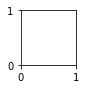

In [5]:
fig, ax = my_plot.instantiate_fig(1, 1)

# XQ vs. HQ - plots from yesterday

In [6]:
df_sec = pd.read_csv('../2022-09-20_sec_proteomics/generated_tables/swath_master_df_ppm.csv')
df_swath = pd.read_csv('./generated_tables/swath_master_df_ppm.csv')

df_all = df_sec.merge(df_swath, how='outer')
df_all = df_all.fillna(0)

df_plot = df_all.drop(columns=['accn', 'name'])
df_plot = df_plot.fillna(0)
df_plot = np.log10(df_plot)
df_plot.replace(-1*np.inf, np.nan, inplace=True)

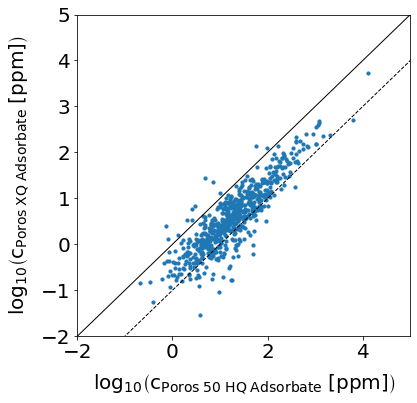

In [11]:
fig, ax = my_plot.instantiate_fig(xlabel=r'$\mathsf{log_{10}\left( c_{Poros \; 50 \; HQ \; Adsorbate} \; [ppm] \right)}$', 
                                  ylabel=r'$\mathsf{log_{10}\left( c_{Poros \; XQ \; Adsorbate} \; [ppm] \right)}$', x=6.2, y=6)

ax.scatter(df_plot.hq_eluate, df_plot.xq_eluate, s=10)

vals = np.array([-2, 5])
ax.set_xlim(vals)
ax.set_ylim(vals)
ax.plot(vals, vals, color='black', linewidth=1)
ax.plot(vals, vals-1, color='black', linewidth=1, linestyle='--')

my_plot.set_layout(fig, ax)
# plt.savefig('./images/12_xq_vs_hq_adsorbate.png', dpi=300)

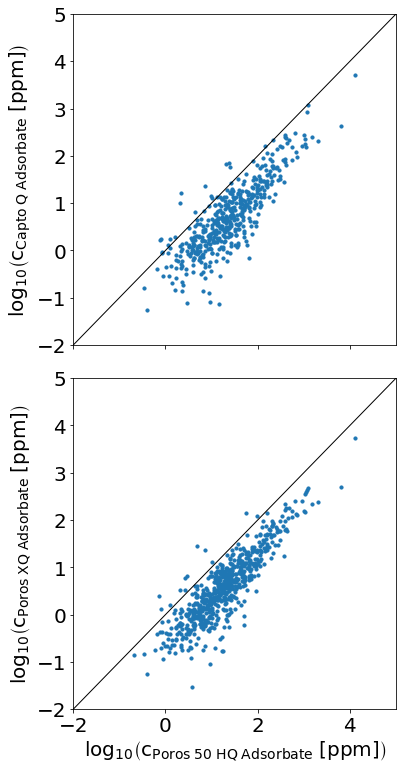

In [9]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
fig.set_size_inches(6, 11, forward=True)

ax[1].set_xlabel(r'$\mathsf{log_{10}\left( c_{Poros \; 50 \; HQ \; Adsorbate} \; [ppm] \right)}$')
ax[1].set_ylabel(r'$\mathsf{log_{10}\left( c_{Poros \; XQ \; Adsorbate} \; [ppm] \right)}$')
ax[0].set_ylabel(r'$\mathsf{log_{10}\left( c_{Capto \; Q \; Adsorbate} \; [ppm] \right)}$')

ax[1].scatter(df_plot.hq_eluate, df_plot.xq_eluate, s=10)
ax[0].scatter(df_plot.hq_eluate, df_plot.cq_eluate, s=10)

vals = np.array([-2, 5])
for i in range(2):
    ax[i].set_xlim(vals)
    ax[i].set_ylim(vals)
    ax[i].plot(vals, vals, color='black', linewidth=1)
#     ax[i].plot(vals, vals-1, color='black', linewidth=1, linestyle='--')

my_plot.set_layout(fig, ax)
plt.savefig('./images/12_xq_and_cq_vs_hq_adsorbate.png', dpi=300)

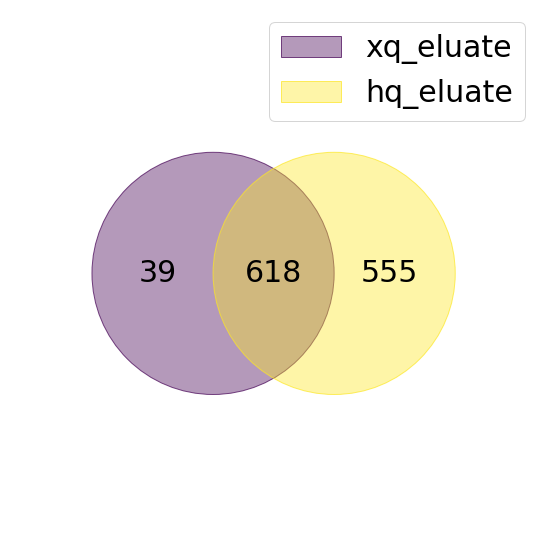

In [15]:
sets = Dict()
for sample in ['xq_eluate', 'hq_eluate']:
    sets[sample] = set(df_swath[df_swath[sample] > 0.0].accn)

fig, ax = my_plot.instantiate_fig(8, 8)
venn(sets, ax=ax, fontsize=30, legend_loc="best")
my_plot.set_layout(fig, ax)  
fig.savefig('./images/12_venn_xq_vs_hq_adsorbate.png', dpi=300)

In [19]:
df = pd.read_csv('./generated_tables/swath_master_df_ppm_with_properties.csv')

df_xq_unique = df[(df.xq_eluate > 0.0) & (df.hq_eluate == 0.0)].copy()
df_hq_unique = df[(df.xq_eluate == 0.0) & (df.hq_eluate > 0.0)].copy()
df_inter = df[(df.xq_eluate > 0.0) & (df.hq_eluate > 0.0)].copy()

In [20]:
groups = ['Poros XQ Adsorbate' for _ in range(len(df_xq_unique))] + ['Intersection' for _ in range(len(df_inter))] + ['Poros 50 HQ Adsorbate' for _ in range(len(df_hq_unique))]
masses = list(df_xq_unique.mass) + list(df_inter.mass) + list(df_hq_unique.mass)
masses = np.array(masses) * 1e-3
iso_pts = list(df_xq_unique.pI) + list(df_inter.pI) + list(df_hq_unique.pI)

df_plot_mass = pd.DataFrame({'group':groups, 'Molecular mass [kDa]':masses})
df_plot_pI = pd.DataFrame({'group':groups, 'Isoelectric point':iso_pts})

In [35]:
# plt.gcf().set_size_inches(7, 6)

# prop = 'Molecular mass [kDa]'
# ax = sns.violinplot(x="group", y=prop, data=df_plot_mass, color=".8", linewidth=2.5, width=0.9, cut=0)

# for artist in ax.lines:
#     artist.set_zorder(10)
# for artist in ax.findobj(PathCollection):
#     artist.set_zorder(11)

# strip = sns.stripplot(x="group", y=prop, data=df_plot_mass, jitter=True, ax=ax, alpha=0.6)
# labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
# hide = ax.set(xlabel=None)
# ax.set_ylim(0, None)
# # plt.savefig('./images/12_violin_mass.png', dpi=300, bbox_inches='tight')

In [36]:
# plt.gcf().set_size_inches(7, 6)

# prop = 'Isoelectric point'
# my_df = df_plot_pI
# ax = sns.violinplot(x="group", y=prop, data=my_df, color=".8", linewidth=2.5, width=0.9, cut=0)

# for artist in ax.lines:
#     artist.set_zorder(10)
# for artist in ax.findobj(PathCollection):
#     artist.set_zorder(11)

# strip = sns.stripplot(x="group", y=prop, data=my_df, jitter=True, ax=ax, alpha=0.6)
# labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
# hide = ax.set(xlabel=None)
# # plt.savefig('./images/12_violin_pI.png', dpi=300, bbox_inches='tight')

In [37]:
f_oneway(*[list(df_xq_unique.mass), list(df_inter.mass), list(df_hq_unique.mass)])

F_onewayResult(statistic=2.2556613477761362, pvalue=0.10524510201359226)

In [38]:
f_oneway(*[list(df_xq_unique.pI), list(df_inter.pI), list(df_hq_unique.pI)])

F_onewayResult(statistic=0.8308199471608836, pvalue=0.4359404909408561)

# New plots

In [21]:
df_aex = pd.read_csv('./generated_tables/swath_master_df_ppm.csv')
df_prev = pd.read_csv('../2022-09-20_sec_proteomics/generated_tables/swath_master_df_ppm.csv')
df_prop = pd.read_csv('./generated_tables/swath_master_df_ppm_with_properties.csv')

df_all = df_prev.merge(df_aex, how='outer')
df_all = df_all.fillna(0)

df_log = df_all.drop(columns=['accn', 'name'])
df_log = df_log.fillna(0)
df_log = np.log10(df_log)
df_log.replace(-1*np.inf, np.nan, inplace=True)

In [22]:
df_enr = df_prop[(df_prop.xq_eluate > df_prop.hq_eluate) & (df_prop.hq_eluate > 0.0)].copy()

In [23]:
groups = ['Unique to\nXQ Adsorbate' for _ in range(len(df_xq_unique))] +\
         ['Intersection' for _ in range(len(df_inter))] +\
         ['Unique to\nHQ Adsorbate' for _ in range(len(df_hq_unique))] +\
         [r'Higher $c_{HCP}$ in XQ' for _ in range(len(df_enr))]

iso_pts = list(df_xq_unique.pI) + list(df_inter.pI) + list(df_hq_unique.pI) + list(df_enr.pI)
masses = list(df_xq_unique.mass) + list(df_inter.mass) + list(df_hq_unique.mass) + list(df_enr.mass)
masses = np.array(masses) * 1e-3

df_plot_mass = pd.DataFrame({'group':groups, 'Molecular mass [kDa]':masses})
df_plot_pI = pd.DataFrame({'group':groups, 'Isoelectric point':iso_pts})

In [34]:
groups = ['Unique to\nXQ Adsorbate', 'Intersection', 'Unique to\nHQ Adsorbate', r'Higher $c_{HCP}$ in XQ']
color_map = {}
for i, group in enumerate(groups):
    color_map[group] = i
        
index_color_map = {}
for i, cont in df_plot_mass.iterrows():
    index_color_map[i] = color_map[cont['group']]

In [37]:
def plot_violin(ylabel, df, index_color_map, xlabel='group'):
    ax = sns.violinplot(x=xlabel, y=ylabel, data=df, linewidth=3, scale='width', color='0.8', inner='stick', cut=0)

    for violin in ax.collections:
        violin.set_alpha(0.3)

    for i, line in enumerate(ax.lines):
        color_index = index_color_map[i]
        line.set_color(f'C{color_index}')
        line.set_linewidth(1.2)
        
    labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
    hide = ax.set(xlabel=None)
        
    return ax

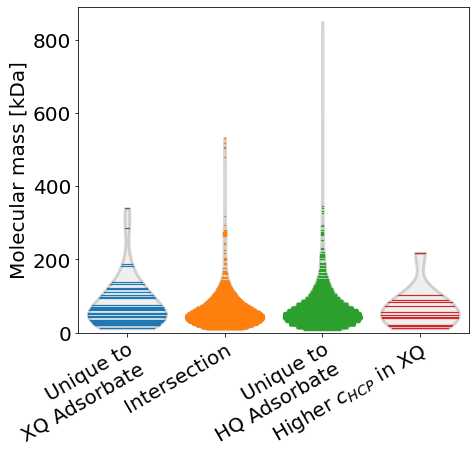

In [45]:
plt.gcf().set_size_inches(7, 6)

ax = plot_violin('Molecular mass [kDa]', df_plot_mass, index_color_map, xlabel='group')
ylim = ax.set_ylim(0, None)

plt.savefig('./images/12_mass_violin_with_sticks.png', dpi=300, bbox_inches='tight')

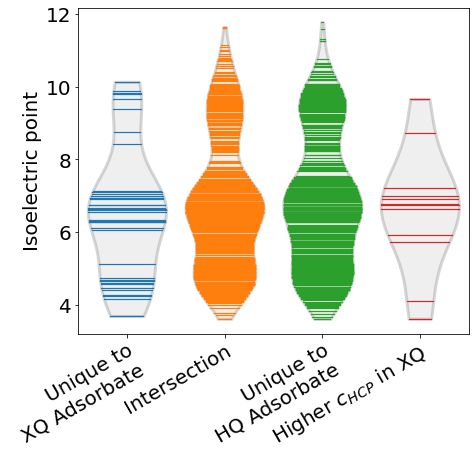

In [40]:
plt.gcf().set_size_inches(7, 6)

ax = plot_violin('Isoelectric point', df_plot_pI, index_color_map, xlabel='group')
plt.savefig('./images/12_pI_violin_with_sticks.png', dpi=300, bbox_inches='tight')

In [41]:
# plt.gcf().set_size_inches(7, 6)

# prop = 'Molecular mass [kDa]'
# ax = sns.violinplot(x="group", y=prop, data=df_plot_mass, color=".8", linewidth=2.5, scale='width', cut=0)

# for artist in ax.lines:
#     artist.set_zorder(10)
# for artist in ax.findobj(PathCollection):
#     artist.set_zorder(11)

# strip = sns.stripplot(x="group", y=prop, data=df_plot_mass, jitter=True, ax=ax, alpha=0.6)
# labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
# hide = ax.set(xlabel=None)
# ax.set_ylim(0, None)
# # plt.savefig('./images/12_mass_violin.png', dpi=300, bbox_inches='tight')

In [42]:
# plt.gcf().set_size_inches(7, 6)

# prop = 'Molecular mass [kDa]'

# ax = sns.stripplot(x="group", y=prop, data=df_plot_mass, jitter=True, alpha=0.6)
# labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
# hide = ax.set(xlabel=None)
# ax.set_ylim(0, None)
# # plt.savefig('./images/12_mass_strip.png', dpi=300, bbox_inches='tight')

In [43]:
# plt.gcf().set_size_inches(7, 6)

# prop = 'Isoelectric point'
# df = df_plot_pI

# ax = sns.violinplot(x="group", y=prop, data=df, color=".8", linewidth=2.5, scale='width', cut=0)

# for artist in ax.lines:
#     artist.set_zorder(10)
# for artist in ax.findobj(PathCollection):
#     artist.set_zorder(11)

# strip = sns.stripplot(x="group", y=prop, data=df, jitter=True, ax=ax, alpha=0.6)
# labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
# hide = ax.set(xlabel=None)
# plt.savefig('./images/12_pI_violin.png', dpi=300, bbox_inches='tight')

In [44]:
# plt.gcf().set_size_inches(7, 6)

# prop = 'Isoelectric point'
# df = df_plot_pI

# ax = sns.stripplot(x="group", y=prop, data=df, jitter=True, alpha=0.6)
# labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
# hide = ax.set(xlabel=None)
# plt.savefig('./images/12_pI_strip.png', dpi=300, bbox_inches='tight')

In [61]:
f_oneway(*[list(df_xq_unique.mass), list(df_inter.mass), list(df_hq_unique.mass), list(df_enr.mass)])

F_onewayResult(statistic=1.5200324716955762, pvalue=0.20757101971538217)

In [62]:
f_oneway(*[list(df_xq_unique.pI), list(df_inter.pI), list(df_hq_unique.pI), list(df_enr.pI)])

F_onewayResult(statistic=0.6305189676490162, pvalue=0.5953637467482646)